## Use cases for `mountain_data_binner` package

Let's assume we want to characterize snow cover on the French Alps on the 22/11/2025 using a snow cover satellite product.

This snow cover product is a daily compoasite fractional snow cover for VIIRS mission produced at Météo-France (Imperatore et al., in prep.). 

The sample data for this example are uploaded in the GitHub project.

In [1]:
# Define inputs and our reduction function. In this case we define the mean as we want to characterize topographically
# the snow presence, but other reduction functions can be defined.

import xarray as xr
from mountain_data_binner.mountain_binner import MountainBinner, MountainBinnerConfig
import os

input_dem_filepath = "../data/DEM_ALPES_NORD_L93_250m_bilinear.tif"
forest_mask_filepath = "../data/FOREST_MASK_ALPES_NORD_EPSG3035_100m.tif"
output_folder = "../output_folder"
snow_cover_data_filepath = "../data/EOFR63JPSS_multisat_20251122.nc"

os.makedirs(output_folder, exist_ok=True)


def target_fun(data: xr.Dataset) -> xr.DataArray:
    """Reduction function, a simple mean."""
    return data.data_vars["snow_cover_fraction"].mean()

### 1. Default behaviour

Designed to match the S2M modelling system [1]

In [2]:
# When init it preprocess DEM and forest data using GDAL
mountain_binner = MountainBinner.from_dem_and_forest_mask_filepath(
    dem_filepath=input_dem_filepath,
    distributed_data_filepath=snow_cover_data_filepath,
    output_folder=output_folder,
    forest_mask_filepath=forest_mask_filepath,
)
s2m_dict = MountainBinner.create_default_bin_dict(altitude_max=4801, altitude_step=300)
snow_cover_dataset = xr.open_dataset(snow_cover_data_filepath, engine="rasterio")
# rescale snow cover fraction to 0 - 100%
snow_cover_dataset = snow_cover_dataset.where(snow_cover_dataset.data_vars["snow_cover_fraction"].values <= 200) / 2

# Binning operation: mapping in topographic and landcover coordinates
binned_dataset = mountain_binner.transform(distributed_data=snow_cover_dataset, bin_dict=s2m_dict, function=target_fun)


INFO:logger:Opening distributed dataset in target geometry
INFO:logger:Opening DEM data
INFO:logger:Resampling DEM to output grid
INFO:logger:Exporting to ../output_folder/dem.tif
INFO:logger:Generating slope map


0...10...20...30...40...50...60

INFO:logger:Exported to ../output_folder/slope.tif


...70...80...90...100 - done.
0...10...20...30...40...50...60

INFO:logger:Exported to ../output_folder/aspect.tif
INFO:logger:Opening distributed dataset un target geometry
INFO:logger:Opening forest mask data


...70...80...90...100 - done.


Text(0.5, 0.98, 'Mean snow cover fraction in semidsitributed projection for slopes in the interval [10 - 30)° on Nort French Alps on 2025/11/22')

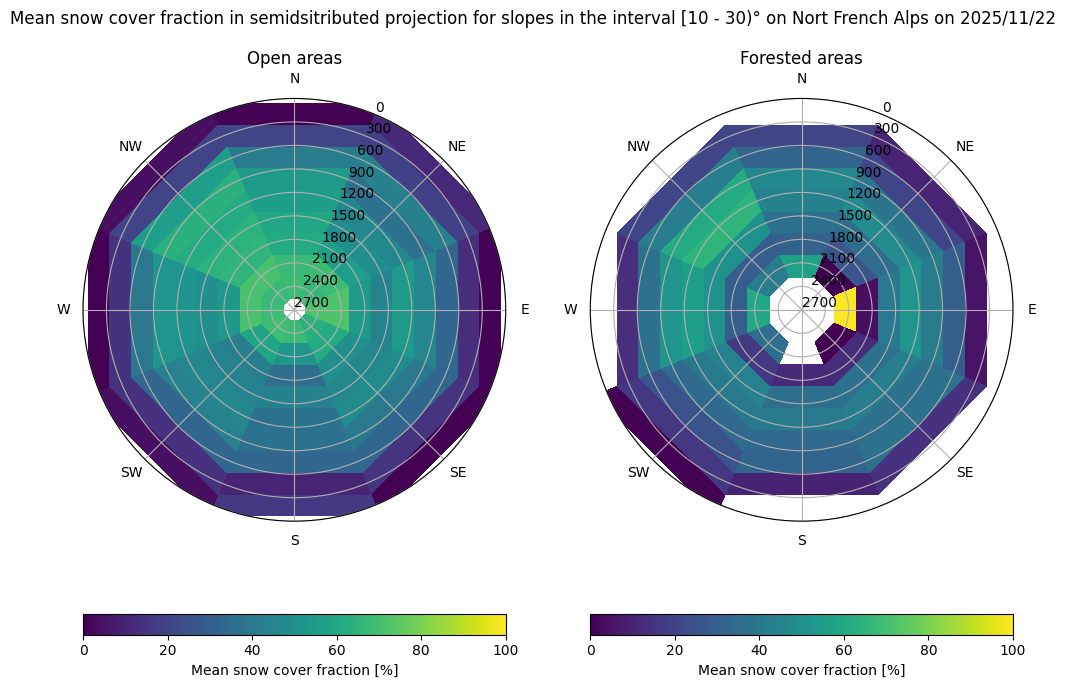

In [3]:
# Visualization: a fancy polar plot of a semidistributed geometry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


# Plot in semidistributed geometry [1]
def semidistributed_geometry_plot(binned_data: xr.DataArray, ax: Axes):
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(binned_data.coords["aspect"].values)
    altitude_ticks = binned_data.coords["altitude_min"].values
    ax.set_rticks(altitude_ticks)
    ax.set_rlim(altitude_ticks[-1], altitude_ticks[0])

    im = ax.pcolor(
        np.deg2rad(np.arange(0, 360, 45)), altitude_ticks, binned_data.values.transpose(), cmap="viridis", vmin=0, vmax=100
    )
    return im


fig, axs = plt.subplots(1, 2, figsize=(12, 8), subplot_kw=dict(projection="polar"))

plot_open = semidistributed_geometry_plot(
    binned_data=binned_dataset.sel(slope_bins="10 - 30", landcover="open", altitude_max=slice(300, 3000)), ax=axs[0]
)
fig.colorbar(plot_open, ax=axs[0], orientation="horizontal", label="Mean snow cover fraction [%]")
axs[0].set_title("Open areas")

plot_forest = semidistributed_geometry_plot(
    binned_data=binned_dataset.sel(slope_bins="10 - 30", landcover="forest", altitude_max=slice(300, 3000)), ax=axs[1]
)
fig.colorbar(plot_open, ax=axs[1], orientation="horizontal", label="Mean snow cover fraction [%]")
axs[1].set_title("Forested areas")
fig.suptitle(
    "Mean snow cover fraction in semidsitributed projection for slopes in the interval [10 - 30)° on Nort French Alps on 2025/11/22"
)

### 2. Custom binning

In [4]:
from mountain_data_binner.mountain_binner import MountainBinner
import numpy as np
import xarray as xr

# When init it preprocess DEM and forest data using GDAL
mountain_binner = MountainBinner.from_dem_and_forest_mask_filepath(
    dem_filepath=input_dem_filepath,
    distributed_data_filepath=snow_cover_data_filepath,
    output_folder=output_folder,
    forest_mask_filepath=forest_mask_filepath,
)

user_dict = mountain_binner.create_user_bin_dict(
    slope_edges=np.arange(0, 61, 30),
    aspect_edges=np.arange(0, 361, 90),
    altitude_edges=np.arange(0, 4001, 500),
    landcover_classes=np.array([0, 1]),
)
mountain_binner.config.regular_8_aspects = (
    False  # If aspect is not defined on N,NE,E,SE,S,SW,W,NW need to set this variable to False
)

# Default binning can be used together with custom binning (MountainBinner.default_slope_bands() MountainBinner.regular_8_aspect_bins(), ..)
user_dict.update(forest_mask=MountainBinner.forest_mask_bins())

snow_cover_dataset = xr.open_dataset(snow_cover_data_filepath, engine="rasterio")
# rescale snow cover fraction to 0 - 100%
snow_cover_dataset = snow_cover_dataset.where(snow_cover_dataset.data_vars["snow_cover_fraction"].values <= 200) / 2

# Binning
binned_dataset_2 = mountain_binner.transform(distributed_data=snow_cover_dataset, bin_dict=user_dict, function=target_fun)


INFO:logger:Opening distributed dataset in target geometry
INFO:logger:Opening DEM data
INFO:logger:Resampling DEM to output grid
INFO:logger:Exporting to ../output_folder/dem.tif
INFO:logger:Generating slope map


0...10...20...30...40...50...60...70

INFO:logger:Exported to ../output_folder/slope.tif


...80...90...100 - done.
0...10...20...30...40...50...60...70...80.

INFO:logger:Exported to ../output_folder/aspect.tif
INFO:logger:Opening distributed dataset un target geometry
INFO:logger:Opening forest mask data


..90...100 - done.


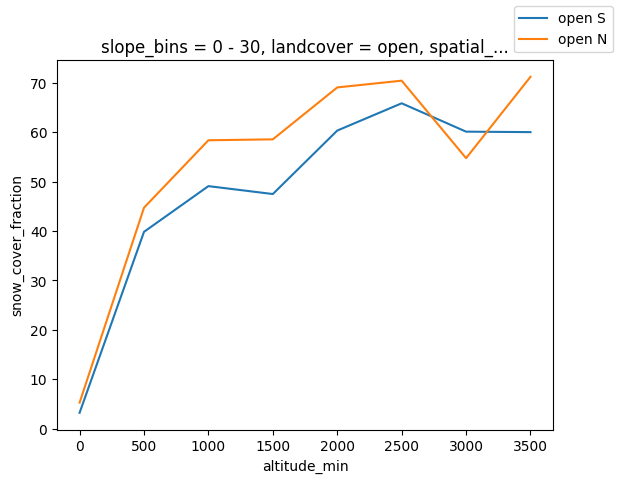

In [5]:
# Visaulization: compare N and S mean snow cover per altitude
import matplotlib.pyplot as plt

fig, axs = plt.subplots()

binned_dataset_2.sel(slope_bins="0 - 30", landcover="open", aspect_min=slice(90, 179)).mean(dim="aspect_bins").plot.line(
    x="altitude_min", ax=axs, label="open S"
)
binned_dataset_2.sel(slope_bins="0 - 30", landcover="open", aspect_bins=["270 - 360", "0 - 90"]).mean(
    dim="aspect_bins"
).plot.line(x="altitude_min", ax=axs, label="open N")
fig.legend()

### 3. Miscellaneous

In [6]:
# It is possible to init a MountainBinner object using slope, aspect, dem, landcover maps via MountainBinnerConfig
# !!! All datasets need to be aligned in the same projection of the geospatial dataset

from mountain_data_binner.mountain_binner import MountainBinner, MountainBinnerConfig

mountain_binner = MountainBinner(
    MountainBinnerConfig(
        slope_map_path="../data/slope.tif",
        aspect_map_path="../data/aspect.tif",
        dem_path="../data/dem.tif",
        forest_mask_path="../data/forest_mask.tif",
    )
)

In [7]:
# It is possible to do a mere topographic projection using Semidistributed object
from mountain_data_binner.semidistributed import Semidistributed
from mountain_data_binner.mountain_binner import MountainBinner, MountainBinnerConfig

semidistirbuted_binner = Semidistributed.from_dem_filepath(
    dem_filepath=input_dem_filepath,
    distributed_data_filepath=snow_cover_data_filepath,
    output_folder=output_folder,
)

# The same result is obtained initiating a MountainBinner object without the forest_mask as binning dimensions are all optional.

semidistirbuted_binner = MountainBinner(
    MountainBinnerConfig(
        slope_map_path="../data/slope.tif",
        aspect_map_path="../data/aspect.tif",
        dem_path="../data/dem.tif",
        forest_mask_path=None,
    )
)

INFO:logger:Opening distributed dataset in target geometry
INFO:logger:Opening DEM data
INFO:logger:Resampling DEM to output grid
INFO:logger:Exporting to ../output_folder/dem.tif
INFO:logger:Generating slope map


0...10...20...30...40...50...60...70...80...90...

INFO:logger:Exported to ../output_folder/slope.tif


100 - done.
0...10...20...30...40...50...60.

INFO:logger:Exported to ../output_folder/aspect.tif


..70...80...90...100 - done.
SemidistributedConfig(slope_map_path='../output_folder/slope.tif', aspect_map_path='../output_folder/aspect.tif', dem_path='../output_folder/dem.tif', regular_8_aspects=True)


### References

[1] M. Vernay et al., « The S2M meteorological and snow cover reanalysis over the French mountainous areas: description and evaluation (1958–2021) », Earth System Science Data, vol. 14, nᵒ 4, p. 1707‑1733, avr. 2022, doi: 10.5194/essd-14-1707-2022.